## SVC

In [1]:
from Functions.Common_functions import *
import pandas as pd

### Load data

In [2]:
dataset_df = formate_dataset()
dataset_df.head()

Relative Compactness Surface area  Wall area Roof area Overall height  \
0              2.06355     -1.59779  -0.269786  -1.42786              1   
1               2.0694     -1.71823  -0.422547  -1.47112              1   
2              2.03073     -1.75999  -0.340612  -1.55169              1   
3              2.01447     -1.72899  -0.581134  -1.40454              1   
4              1.30869     -1.34281 -0.0477237  -1.28699              1   

  Glazing area GAD : 0 GAD : 1 GAD : 2 GAD : 3 GAD : 4 GAD : 5 East North  \
0     -1.64028       1       0       0       0       0       0    0     1   
1     -1.83179       1       0       0       0       0       0    1     0   
2     -1.76649       1       0       0       0       0       0    0     0   
3     -1.76117       1       0       0       0       0       0    0     0   
4     -1.81079       1       0       0       0       0       0    0     1   

  South West   Energy Energy efficiency  
0     0    0  34.2639                 B  
1     0    0  34.5898                 B  
2     1    0   38.778                 C  
3     0    1  37.9478                 C  
4     0    0  47.6759                 D

### Create test set

In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train_r, y_test_r = train_test_split(dataset_df[dataset_df.columns[0:16]], dataset_df['Energy'], test_size=0.20, random_state=42)
_, _, y_train_b, y_test_b = train_test_split(dataset_df[dataset_df.columns[0:16]], dataset_df['Energy efficiency'], test_size=0.20, random_state=42) 

In [4]:
y_train_b.head()

60     D
618    C
346    E
294    E
231    A
Name: Energy efficiency, dtype: object

### ACP on the train set

In [5]:
import numpy as np

acp_df = pd.concat([X_train, y_train_r, y_train_b], axis=1)
acp_df = acp_df.drop(acp_df.columns[np.arange(6, 16)], axis = 1,)
acp_df.head()

Relative Compactness Surface area  Wall area Roof area Overall height  \
60              0.531311    -0.745559 -0.0780456 -0.689514              1   
618              -1.1574      1.29257   0.534939   1.00118             -1   
346              0.84627      -1.0325  -0.700866 -0.666789              1   
294              1.23387     -1.18323   0.113668  -1.20972              1   
231             -1.02421      1.09848  0.0316101   1.05643             -1   

    Glazing area   Energy Energy efficiency  
60     -0.991289  50.4874                 D  
618      1.23737  42.2901                 C  
346     0.082403  57.9177                 E  
294     0.118502  64.3365                 E  
231     -1.02533  27.1754                 A

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# get name of columns in a list
columns = list(acp_df.columns)

# create a normalization for "Energy" column 
preprocessor_y = ColumnTransformer(
    transformers=[
        ('scale_y', StandardScaler(), ['Energy'])], remainder='passthrough')

acp_df = preprocessor_y.fit_transform(acp_df)

In [7]:
# Efficiency is the first column due to ColumnTransformation
columns.insert(0, columns.pop(-1))
acp_df = pd.DataFrame(data=acp_df, columns = columns)

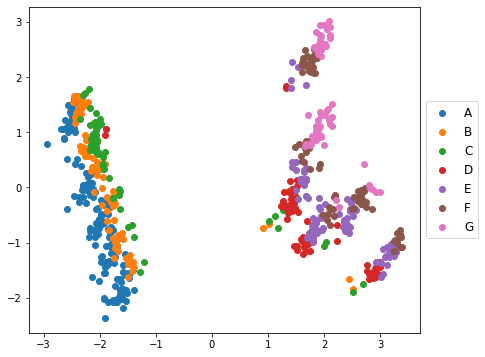

In [8]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt


pca = PCA(n_components=2, svd_solver="full")

X2D = pca.fit_transform(acp_df.drop(['Energy'], axis=1))

d = {"pc1": X2D[:, 0], "pc2": X2D[:, 1], "Energy_label": acp_df.Energy}
X2D = pd.DataFrame(data=d)

plt.figure(figsize=(7,6))

def plot_classification_pca(subplot=plt):
    list_labels = ["A","B","C", "D", "E", "F", "G"]
    for value in list_labels:
        subplot.scatter(X2D["pc1"].where(X2D["Energy_label"]==value), X2D["pc2"].where(X2D["Energy_label"]==value),  label=value)
    subplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
        
plot_classification_pca()

## SVC

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

### Linear SVC

In [10]:
X_train_acp = X2D[['pc1','pc2']]
y_train_acp = X2D['Energy_label']
y_train_nb = y_train_acp.replace(["A","B","C", "D", "E", "F", "G"], np.arange(1,8))

In [11]:
svc = SVC(class_weight='balanced', kernel='linear')

svc.fit(X_train_acp, y_train_nb)

SVC(class_weight='balanced', kernel='linear')

In [12]:
svc.classes_

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [13]:
from matplotlib.colors import LinearSegmentedColormap

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def create_cmap():
    cmap_name = 'my_list'
    colors = ["cornflowerblue", "burlywood", "limegreen", "indianred", "mediumpurple", "chocolate", "pink"]  
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=7)
    

In [14]:
X_train_acp

pc1       pc2
0    1.431403 -0.427482
1   -1.982280  1.147162
2    1.832239 -0.829299
3    2.514924 -0.193318
4   -2.292848  0.022710
..        ...       ...
609  1.688407  2.383923
610  1.620801 -0.887995
611 -1.749205 -1.173828
612  3.154756 -1.251489
613  2.354348 -0.583489

[614 rows x 2 columns]

In [15]:
X_train_acp.shape

(614, 2)

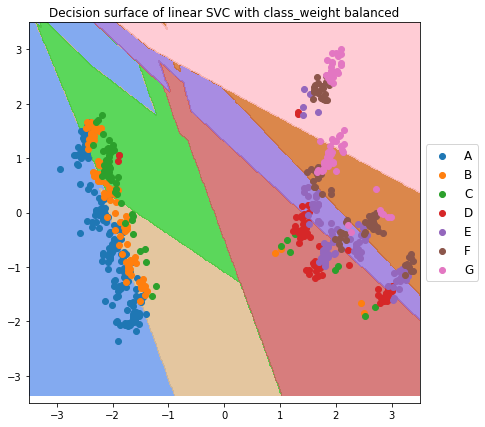

In [16]:
def plot_svc(model, title):
    fig, ax = plt.subplots(figsize=(7,7))# title for the plots
    
    # Set-up grid for plotting.
    X0, X1 = X_train_acp.pc1, X_train_acp.pc2
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, svc, xx, yy, cmap=create_cmap(), alpha=0.8)
    plot_classification_pca()

    ax.set_xlim(-3.5,3.5)
    ax.set_ylim(-3.5,3.5)
    ax.set_title(title)
    plt.show()
    
plot_svc(model=svc, title="Decision surface of linear SVC with class_weight balanced")

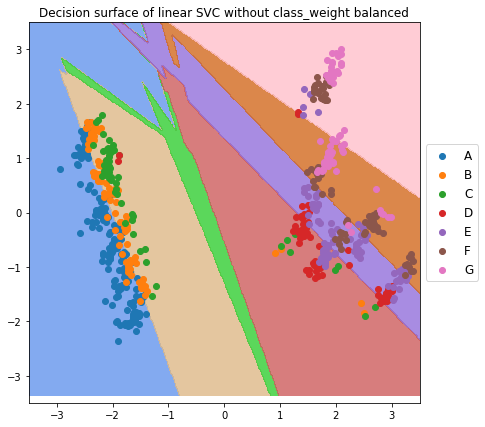

In [17]:
svc = SVC(kernel='linear')
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Decision surface of linear SVC without class_weight balanced")

### Other kernels

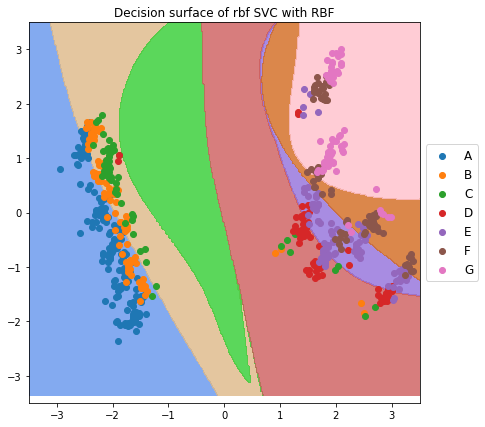

In [18]:
svc = SVC(kernel='rbf')
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Decision surface of rbf SVC with RBF")

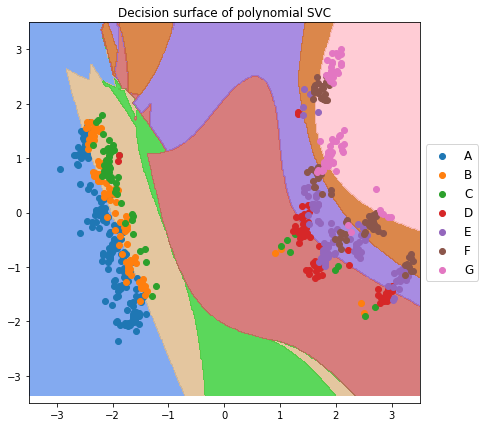

In [19]:
svc = SVC(kernel='poly', degree=3)
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Decision surface of polynomial SVC")

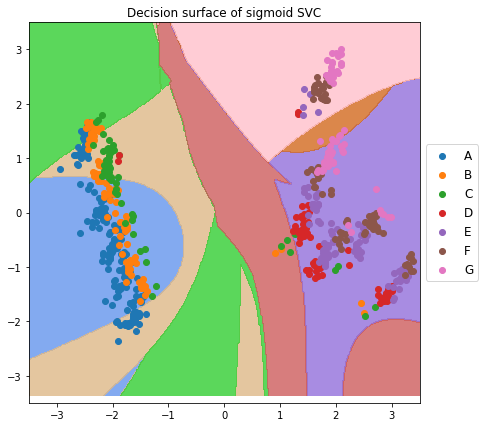

In [20]:
svc = SVC(kernel='sigmoid')
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Decision surface of sigmoid SVC")

We can say rbf and polynomial third degree svc are performant in our case and we are going to improve them through other classifiers.

### Gamma

Gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set. We are going to test this parameter on RBF SVC.

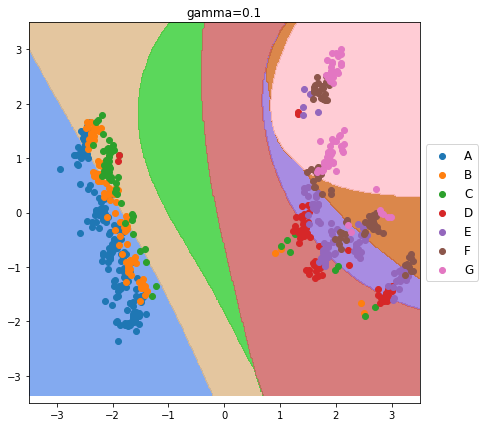

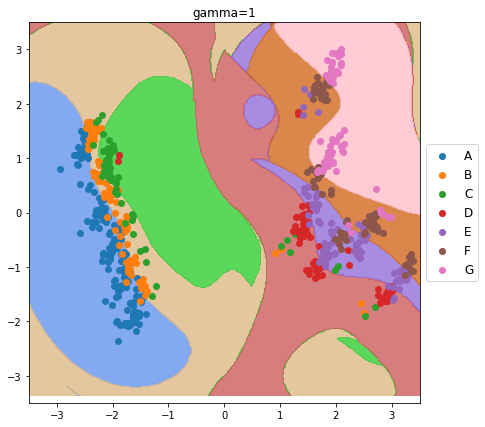

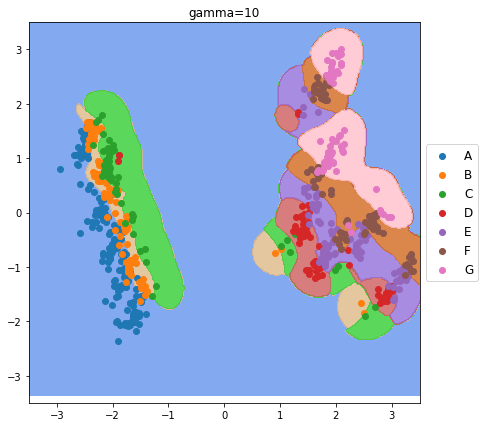

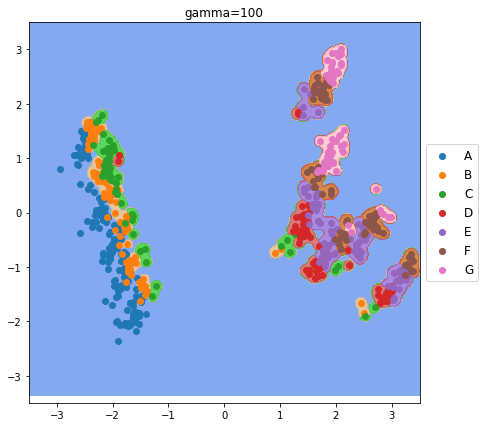

In [21]:
gammas = [0.1, 1, 10, 100]
for gamma in gammas:
   svc = SVC(kernel='rbf', gamma=gamma).fit(X_train_acp, y_train_nb)
   plot_svc(svc, 'gamma=' + str(gamma))

The classifier is well fitting the data when gamma=10. When gamma=100, it is obvious that the classifier is overfitting. We can try a gamma=10 with the polynomial kernel.

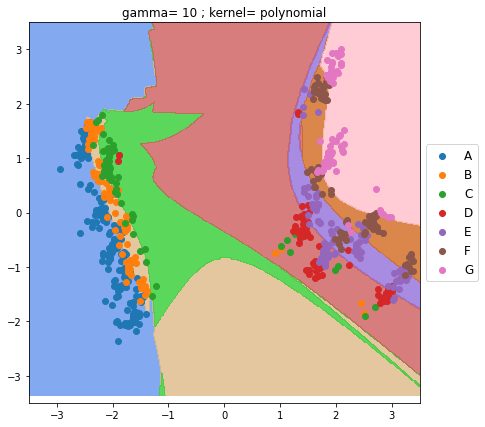

In [22]:
svc = SVC(kernel='poly', gamma=10).fit(X_train_acp, y_train_nb)
plot_svc(svc, 'gamma= 10 ; kernel= polynomial')

### Penalty parameter 

C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly. Higher is C, less margin encroachment there will be.

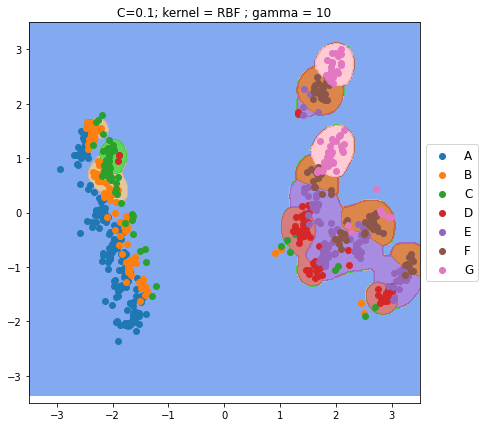

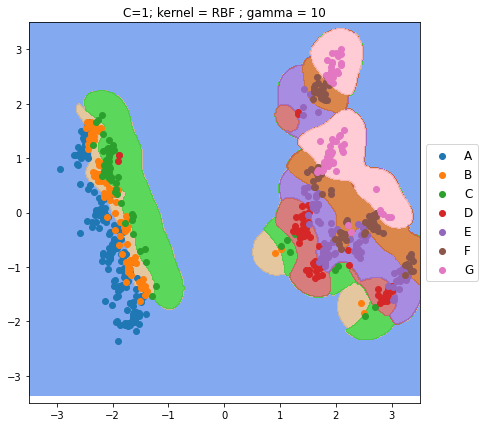

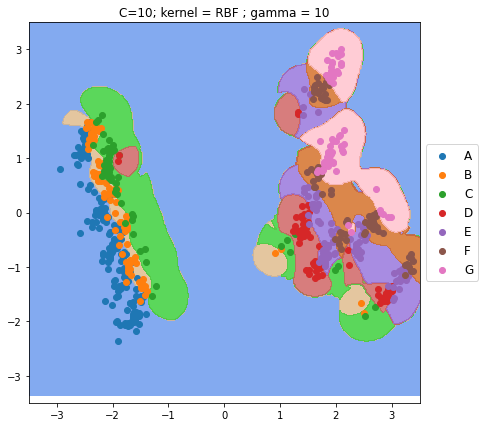

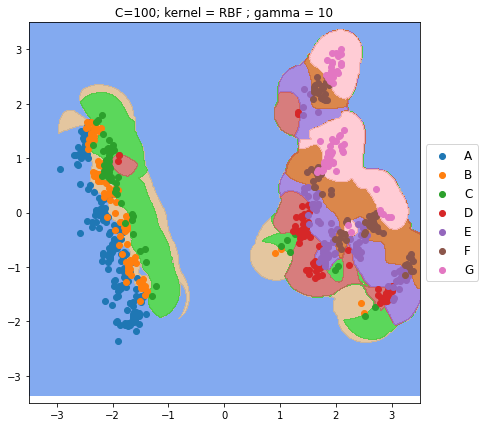

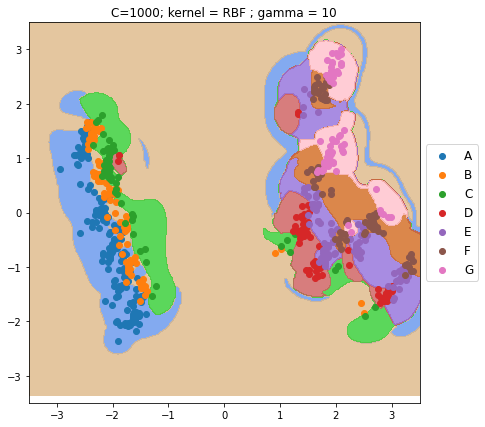

In [23]:
C_list = [0.1, 1, 10, 100, 1000]
for C in C_list:
    svc = SVC(kernel='rbf', gamma=10, C=C).fit(X_train_acp, y_train_nb)
    plot_svc(svc, 'C=' + str(C) + '; kernel = RBF ; gamma = 10')

We can see that a high value of C leads to overfit the data. The model with C=10 seems to be the best. 
We can retrieve the polynomial model and fine tune it thanks to the parameter degree.

### Degree

In [24]:
COMPUTE = False
degrees = [1, 2, 3, 4]

if(COMPUTE==True):
    for degree in degrees:
        svc = SVC(kernel='poly', gamma=10, C=10, degree=degree).fit(X_train_acp, y_train_nb)
        plot_svc(svc, 'C=' + str(C) + '; kernel = RBF ; gamma = 10')

## Cross validation

Because we have fine-tune the parameters displaying an ACP recovering 85% of inertia, we are not sure our model is perfectly fine-tuned. Moreover, we have tried very sparse values therefore we have not been accurate tuning parameters.

We are going to use a cross validation to see if our estamations were good in the first time and fine-tune the parameters in a second time.

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(cache_size=1000, kernel='rbf')

params={"C": C_list,
       "gamma": gammas,
       "class_weight": [None, "balanced"]}

clf = GridSearchCV(estimator=svc, param_grid=params, n_jobs=-1)
  
clf.fit(X_train_acp, y_train_b)

classifier = clf.best_estimator_
clf.best_params_

{'C': 10, 'class_weight': None, 'gamma': 10}

Our estimations regarding ACP are conform to the train test with 100% of inertia. Let's fine-tune our model.

## Fine-tune model

In [26]:
svc = SVC(cache_size=1000, kernel='rbf', class_weight=None)

params={"C": [5, 10, 20, 30, 40],
       "gamma": [5, 10, 20, 30, 40]}

clf = GridSearchCV(estimator=svc, param_grid=params, n_jobs=-1)
  
clf.fit(X_train_acp, y_train_b)

classifier = clf.best_estimator_
clf.best_params_

{'C': 10, 'gamma': 10}

In [27]:
params={"C": np.arange(6,20),
       "gamma": np.arange(6,20)}

clf = GridSearchCV(estimator=svc, param_grid=params, n_jobs=-1)
  
clf.fit(X_train_acp, y_train_b)
clf.best_params_

{'C': 16, 'gamma': 13}

In [28]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(clf.best_estimator_, X_train_acp, y_train_b, cv=3))

0.8143631436314364

## Test without ACP

We must get rid of the quantitative features because SVC does not work well with this kind of features.

In [29]:
X_test_no_acp = X_test.drop(X_test.columns[6:], axis=1)
X_train_no_acp = X_train.drop(X_train.columns[6:], axis=1)
X_train_no_acp

Relative Compactness Surface area  Wall area Roof area Overall height  \
60              0.531311    -0.745559 -0.0780456 -0.689514              1   
618              -1.1574      1.29257   0.534939   1.00118             -1   
346              0.84627      -1.0325  -0.700866 -0.666789              1   
294              1.23387     -1.18323   0.113668  -1.20972              1   
231             -1.02421      1.09848  0.0316101   1.05643             -1   
..                   ...          ...        ...       ...            ...   
71            -0.0796889   -0.0330695    2.43802  -1.21718              1   
106             0.887435     -0.91031  -0.454605 -0.667249              1   
270            -0.544992     0.417522   -1.07957  0.932067             -1   
435              2.05907      -1.8313    -0.5264  -1.53097              1   
102              1.30002     -1.20226  0.0272476   -1.1863              1   

    Glazing area  
60     -0.991289  
618      1.23737  
346     0.082403  
294     0.118502  
231     -1.02533  
..           ...  
71       -1.0029  
106    -0.893534  
270    -0.912963  
435    0.0492024  
102    -0.999601  

[614 rows x 6 columns]

In [30]:
clf.best_params_

{'C': 16, 'gamma': 13}

In [31]:
clf_no_acp = GridSearchCV(estimator=svc, param_grid={'C': np.linspace(0,1,10),'gamma': np.arange(1,6)}, n_jobs=-1,cv=4)
  
clf_no_acp.fit(X_train_no_acp, y_train_b)

GridSearchCV(cv=4, estimator=SVC(cache_size=1000), n_jobs=-1,
             param_grid={'C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'gamma': array([1, 2, 3, 4, 5])})

In [32]:
clf_no_acp.best_params_

{'C': 0.8888888888888888, 'gamma': 2}

In [34]:
clf_no_acp.best_estimator_.score(X_test_no_acp, y_test_b)

0.6623376623376623

## Test directly on ACP

In [35]:
test_df = pd.concat([X_test, y_test_r, y_test_b], axis=1)
test_df = test_df.drop(test_df.columns[np.arange(6, 16)], axis = 1,)
test_df.head()

Relative Compactness Surface area  Wall area Roof area Overall height  \
668             -1.35233      1.57991    1.10843   1.00281             -1   
324             -1.09066     0.996305 -0.0287256  0.986061             -1   
624               2.0698     -1.75115  -0.474339  -1.47807              1   
690             0.317966    -0.475846   0.476161 -0.695707              1   
473             -1.15061      1.20098   0.543645  0.907583             -1   

    Glazing area   Energy Energy efficiency  
668      1.28104  37.0519                 C  
324  -0.00387293  29.0073                 A  
624      1.29481  69.3006                 F  
690      1.19014  83.2745                 G  
473     0.185127  34.2254                 B

### Prepare test set by transforming X_test in two principal componants

In [36]:
# get name of columns in a list
columns = list(test_df.columns)

# create a normalization for "Energy" column 
preprocessor_y = ColumnTransformer(
    transformers=[
        ('scale_y', StandardScaler(), ['Energy'])], remainder='passthrough')

test_df = preprocessor_y.fit_transform(test_df)

In [37]:
# Efficiency is the first column due to ColumnTransformation
columns.insert(0, columns.pop(-1))
test_df = pd.DataFrame(data=test_df, columns = columns)
test_df.head()

Energy efficiency Relative Compactness Surface area  Wall area Roof area  \
0         -0.573506             -1.35233      1.57991    1.10843   1.00281   
1         -0.978319             -1.09066     0.996305 -0.0287256  0.986061   
2           1.04927               2.0698     -1.75115  -0.474339  -1.47807   
3           1.75245             0.317966    -0.475846   0.476161 -0.695707   
4         -0.715738             -1.15061      1.20098   0.543645  0.907583   

  Overall height Glazing area Energy  
0             -1      1.28104      C  
1             -1  -0.00387293      A  
2              1      1.29481      F  
3              1      1.19014      G  
4             -1     0.185127      B

In [38]:
X2D_test = pca.transform(test_df.drop(['Energy'], axis=1))

d = {"pc1": X2D_test[:, 0], "pc2": X2D_test[:, 1], "Energy_label": test_df.Energy}
X2D_test = pd.DataFrame(data=d)


In [39]:
X2D_test = X2D_test.drop("Energy_label",axis=1)

In [40]:
X2D_test.head()

pc1       pc2
0 -2.301778  1.652467
1 -2.213682  0.132770
2  3.316178 -0.858269
3  1.979573  1.028083
4 -2.137780  0.799013

In [41]:
y_test_b

668    C
324    A
624    F
690    G
473    B
      ..
355    G
534    F
344    E
296    E
462    A
Name: Energy efficiency, Length: 154, dtype: object

In [42]:
y_test_nb = y_test_b.replace(["A","B","C", "D", "E", "F", "G"], np.arange(1,8))

In [43]:
print('Coefficient de determination: %.2f'
      % clf.best_estimator_.score(X2D_test, y_test_b))

Coefficient de determination: 0.78


We have significantly better results with ACP. It is possible that is because of the noise added to the values

### Analyse des erreurs

In [47]:
from Functions.Classification_Functions import display_conf_matrix, plot_error_analysis

[[38  1  0  0  0  0  0]
 [ 6  7  1  0  0  0  0]
 [ 0 11  9  1  1  0  0]
 [ 0  0  0 13  1  0  0]
 [ 0  0  0  1 23  1  0]
 [ 0  0  0  0  5 17  2]
 [ 0  0  0  0  0  3 13]]


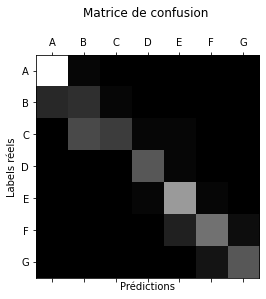

In [82]:
y_test_pred = clf.best_estimator_.predict(X2D_test)
conf_mx = confusion_matrix(y_test_b, y_test_pred)
display_conf_matrix(conf_mx)

As we can see, it is difficult for the classifier to class correctly B and C. It confuses the B with the A and the C with the B. 
It is due to the rapprochement between this labels on the ACP visualisation.

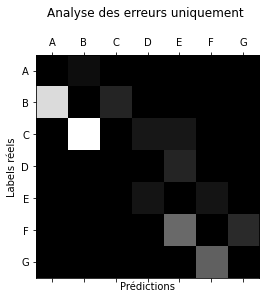

In [49]:
plot_error_analysis(conf_mx)

### Precision, recall, f1_score

In [78]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true=y_test_b, y_pred=y_test_pred, average='macro')

(0.777368746541679, 0.7504078064792351, 0.7470836669030446, None)

In [81]:
from sklearn.metrics import classification_report

# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.864     0.974     0.916        39
           B      0.368     0.500     0.424        14
           C      0.900     0.409     0.563        22
           D      0.867     0.929     0.897        14
           E      0.767     0.920     0.836        25
           F      0.810     0.708     0.756        24
           G      0.867     0.812     0.839        16

    accuracy                          0.779       154
   macro avg      0.777     0.750     0.747       154
weighted avg      0.800     0.779     0.773       154



C is the worst classified clas because it is scattered in other classes (like D and E). Moreover, it is at the frontier of the B labels in ACP visualisation. Rest of the classes are well classified.

### SVM with duplication

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled_b = ros.fit_resample(X= dataset_df[dataset_df.columns[0:16]], y=dataset_df["Energy efficiency"])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
y_resampled_b.value_counts().sort_index().plot.bar()

### Create test set

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_res_train, X_res_test, y_res_train_b, y_res_test_b = train_test_split(X_resampled, y_resampled_b, 
                                             test_size=0.20, random_state=42)



In [ ]:
import warnings
warnings.filterwarnings('ignore')

# search_enet = GridSearchCV(estimator=LogisticRegression(solver='saga', max_iter=1000000),
#              param_grid={'C': np.linspace(0, 0.10, 50), 'penalty': ['elasticnet'], 
#                          'l1_ratio' : [0.1, 0.3, 0.4, 0.5, 0.6, 0.7]},
#              cv=3)

search_l1.fit(X_res_train, y_res_train_b)
print(search_l1.best_params_)

score_l1 = cross_val_score(search_l1.best_estimator_, X_res_train, y_res_train_b, cv=5)
score_l1.mean()


In [ ]:
search_l1.best_estimator_.score(X_res_test, y_res_test_b)


This over sampling is not very performant because it is the same as specify the balanced weight class in the classifier. Therefore, we are going to implement other over sampling technics.

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

model = Pipeline([
        ('sampling', SMOTE(random_state=12)),
        ('logistic', LogisticRegression())
    ])

grid = GridSearchCV(model, estimator=LogisticRegression(solver='saga', max_iter=10e100),
             param_grid={'logistic__C': np.linspace(0, 0.10, 50), 
                         'logistic__penalty': ['l1'], 
                         'logistic__solver': ['saga', 'liblinear'],
                         'logistic__class_weight': ['balanced', None]},
             cv=3)

grid.fit(X_train, y_train_b)
print(grid.best_params_)
grid.best_estimator_.score(X_test, y_test_b)

In [ ]:
from imblearn.over_sampling import ADASYN
warnings.filterwarnings('ignore')

model = Pipeline([
        ('sampling', ADASYN(random_state=12)),
        ('logistic', LogisticRegression())
    ])

grid.fit(X_train, y_train_b)
grid.best_estimator_.score(X_test, y_test_b)